<a href="https://colab.research.google.com/github/PurpleBeetle/IA1900/blob/main/Tarea2_2_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entrenamiento R²: 0.9357013570967945
Test R²: 0.9328188279581249
RMSE: 30310.30638398898


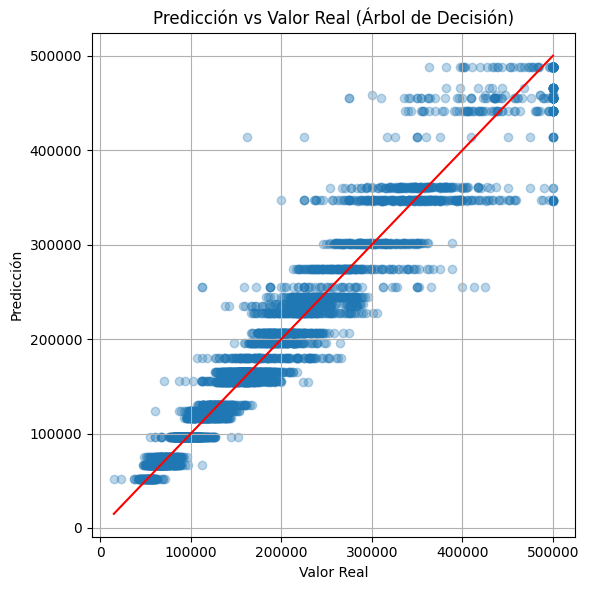

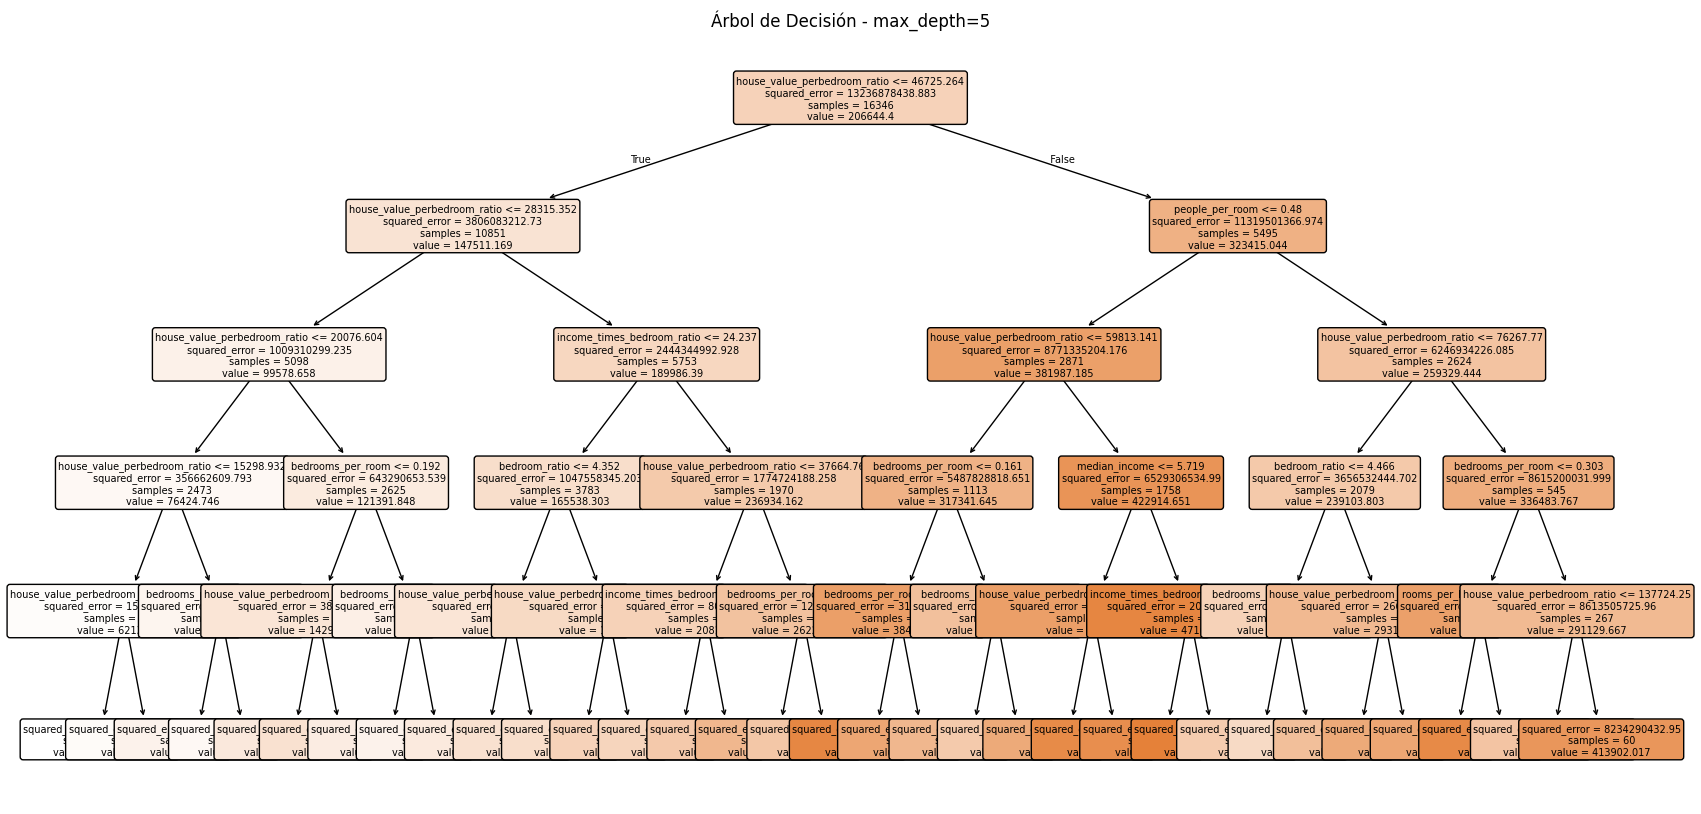

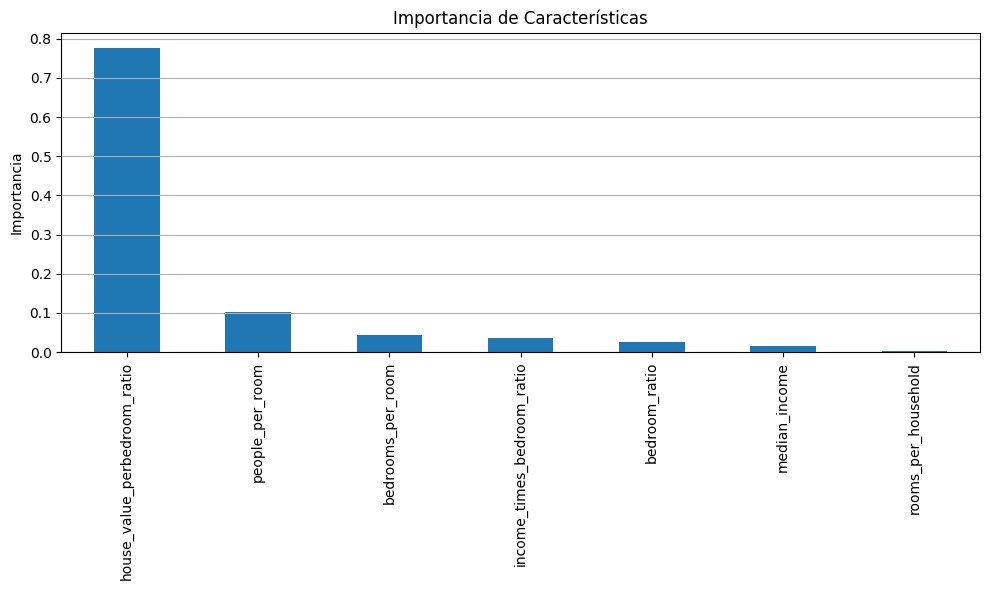

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('./housing.csv')

# Guardamos la columna 'ocean_proximity' con un nuevo nombre 'region' para hacer analisis por zonas
df['region'] = df['ocean_proximity']

# Agrupamos por region y calculamos los promedios de ingreso de la casa por region
region_means = df.groupby('region')[['median_income', 'median_house_value']].mean()

# Creamos una nueva columna que representa la relacion ingreso de la casa por región
region_means['region_income_ratio'] = region_means['median_income'] / region_means['median_house_value']

# Unimos esta nueva columna al DataFrame original para cada fila segun su region
df = df.merge(region_means['region_income_ratio'], on='region', how='left')

# Convertimos la columna categorica 'region' en columnas dummy (0 o 1 por region)
df = pd.concat([df, pd.get_dummies(df['region'], dtype=int)], axis=1)

# Eliminamos columnas que ya no necesitamos
df.drop(['ocean_proximity', 'region'], axis=1, inplace=True)

# Eliminamos cualquier fila que tenga datos faltantes (NaN)
df.dropna(inplace=True)

# Creamos nuevas columnas (features) a partir de combinaciones de las ya existentes

# Estas ayudan a que el modelo tenga mas contexto y aprenda mejor
df['bedroom_ratio'] = df['total_rooms'] / df['total_bedrooms']                 # Cuartos por dormitorio
df['rooms_per_household'] = df['total_rooms'] / df['households']               # Cuartos por hogar
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']             # Proporcion de dormitorios respecto a los cuartos
df['population_per_household'] = df['population'] / df['households']           # Personas por hogar
df['income_per_person'] = df['median_income'] / df['population']               # Ingreso por persona
df['people_per_room'] = df['population'] / df['total_rooms']                   # Personas por cuarto
df['households_per_room'] = df['households'] / df['total_rooms']               # Hogares por cuarto
df['income_times_rooms'] = df['median_income'] * df['total_rooms']             # Ingreso total en relacion con cantidad de cuartos
df['income_times_bedroom_ratio'] = df['median_income'] * df['bedroom_ratio']   # Ingreso ponderado por relacion de cuartos
df['house_value_perbedroom_ratio'] = df['median_house_value'] / df['bedroom_ratio'] # El valor de la casa sobre los cuartos
df['log_total_rooms'] = np.log1p(df['total_rooms'])                            # Logaritmo de total de cuartos (reduce valores extremos)
df['log_population'] = np.log1p(df['population'])                              # Logaritmo de poblacion (reduce valores extremos)

# Creamos variables que representan zonas geográficas por latitud y longitud

df['near_coast'] = ((df['longitude'] > -124) & (df['latitude'] > 32)).astype(int)  # Cerca de la costa sur de California
df['far_north'] = (df['latitude'] > 38).astype(int)                                # En el norte de California
df['central_ca'] = ((df['latitude'] >= 35) & (df['latitude'] <= 37)).astype(int)   # Zona central de California


# Agrupamos los ingresos en categorias discretas (muy bajo, bajo, medio, etc.)
df['income_level'] = pd.cut(df['median_income'],
                            bins=[0, 2, 4, 6, 8, np.inf],
                            labels=['muy_bajo', 'bajo', 'medio', 'alto', 'muy_alto'])

# Convertimos esa columna categorica en variables dummy (0 o 1 por categoria)
df = pd.get_dummies(df, columns=['income_level'], dtype=int)

# Separamos las variables de entrada (X) de la variable objetivo (y)
X = df.drop('median_house_value', axis=1)   # Todas las columnas menos el precio de la casa
y = df['median_house_value']                # Precio de la casa (target)

# Dividimos el dataset en datos de entrenamiento y de prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Árbol de Decision
modelo = DecisionTreeRegressor(random_state=42, max_depth=5)
modelo.fit(X_train, y_train)

# Prediccion
predicciones = modelo.predict(X_test)

# Evaluacion
print("Entrenamiento R²:", modelo.score(X_train, y_train))
print("Test R²:", modelo.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predicciones)))

# Grafico de dispersion: Real vs Prediccion
plt.figure(figsize=(6,6))
plt.scatter(y_test, predicciones, alpha=0.3)
plt.xlabel("Valor Real")
plt.ylabel("Prediccion")
plt.title("Prediccion vs Valor Real (Arbol de Decision)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualizacion del arbol
plt.figure(figsize=(20,10))
plot_tree(modelo, feature_names=X.columns, filled=True, rounded=True, fontsize=7)
plt.title("Arbol de Decision - max_depth=5")
plt.show()

# Importancia de caracteristicas
importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias = importancias[importancias > 0].sort_values(ascending=False)

plt.figure(figsize=(10,6))
importancias.plot(kind='bar')
plt.title("Importancia de Caracteristicas")
plt.ylabel("Importancia")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


Árbol de Decisión de Regresión
Lógica del modelo:

    Divide los datos en segmentos basados en condiciones (por ejemplo: "si la variable X > 3.2").

    Cada nodo representa una decisión basada en una característica.

    Las hojas contienen un valor promedio de y para ese grupo.

Ventajas:

    Captura relaciones no lineales.

    Fácil de visualizar e interpretar.

    No necesita escalado de datos.

Desventajas:

    Propenso a overfitting (por eso se controla con max_depth, min_samples_split, etc.).

    Puede ser inestable con pequeños cambios en los datos.

    A veces no generaliza bien en datos nuevos si el árbol es muy profundo.

Entrenamiento R²: 0.9976658231812983
Test R²: 0.9913835382169158
RMSE: 10855.029830440613


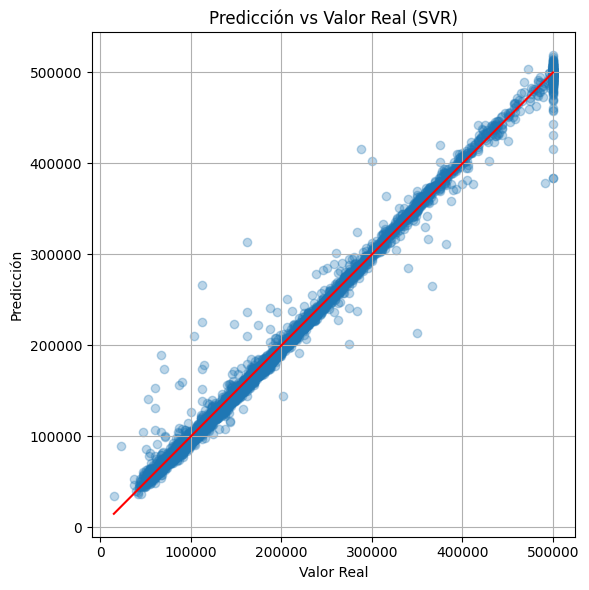

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('./housing.csv')

# Guardamos la columna 'ocean_proximity' con un nuevo nombre 'region' para hacer analisis por zonas
df['region'] = df['ocean_proximity']

# Agrupamos por region y calculamos los promedios de ingreso de la casa por region
region_means = df.groupby('region')[['median_income', 'median_house_value']].mean()

# Creamos una nueva columna que representa la relacion ingreso de la casa por región
region_means['region_income_ratio'] = region_means['median_income'] / region_means['median_house_value']

# Unimos esta nueva columna al DataFrame original para cada fila segun su region
df = df.merge(region_means['region_income_ratio'], on='region', how='left')

# Convertimos la columna categorica 'region' en columnas dummy (0 o 1 por region)
df = pd.concat([df, pd.get_dummies(df['region'], dtype=int)], axis=1)

# Eliminamos columnas que ya no necesitamos
df.drop(['ocean_proximity', 'region'], axis=1, inplace=True)

# Eliminamos cualquier fila que tenga datos faltantes (NaN)
df.dropna(inplace=True)

# Creamos nuevas columnas (features) a partir de combinaciones de las ya existentes

# Estas ayudan a que el modelo tenga mas contexto y aprenda mejor
df['bedroom_ratio'] = df['total_rooms'] / df['total_bedrooms']                 # Cuartos por dormitorio
df['rooms_per_household'] = df['total_rooms'] / df['households']               # Cuartos por hogar
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']             # Proporcion de dormitorios respecto a los cuartos
df['population_per_household'] = df['population'] / df['households']           # Personas por hogar
df['income_per_person'] = df['median_income'] / df['population']               # Ingreso por persona
df['people_per_room'] = df['population'] / df['total_rooms']                   # Personas por cuarto
df['households_per_room'] = df['households'] / df['total_rooms']               # Hogares por cuarto
df['income_times_rooms'] = df['median_income'] * df['total_rooms']             # Ingreso total en relacion con cantidad de cuartos
df['income_times_bedroom_ratio'] = df['median_income'] * df['bedroom_ratio']   # Ingreso ponderado por relacion de cuartos
df['house_value_perbedroom_ratio'] = df['median_house_value'] / df['bedroom_ratio'] # El valor de la casa sobre los cuartos
df['log_total_rooms'] = np.log1p(df['total_rooms'])                            # Logaritmo de total de cuartos (reduce valores extremos)
df['log_population'] = np.log1p(df['population'])                              # Logaritmo de poblacion (reduce valores extremos)

# Creamos variables que representan zonas geográficas por latitud y longitud

df['near_coast'] = ((df['longitude'] > -124) & (df['latitude'] > 32)).astype(int)  # Cerca de la costa sur de California
df['far_north'] = (df['latitude'] > 38).astype(int)                                # En el norte de California
df['central_ca'] = ((df['latitude'] >= 35) & (df['latitude'] <= 37)).astype(int)   # Zona central de California


# Agrupamos los ingresos en categorias discretas (muy bajo, bajo, medio, etc.)
df['income_level'] = pd.cut(df['median_income'],
                            bins=[0, 2, 4, 6, 8, np.inf],
                            labels=['muy_bajo', 'bajo', 'medio', 'alto', 'muy_alto'])

# Convertimos esa columna categorica en variables dummy (0 o 1 por categoria)
df = pd.get_dummies(df, columns=['income_level'], dtype=int)

# Separamos las variables de entrada (X) de la variable objetivo (y)
X = df.drop('median_house_value', axis=1)   # Todas las columnas menos el precio de la casa
y = df['median_house_value']                # Precio de la casa (target)

# Dividimos el dataset en datos de entrenamiento y de prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Escalar datos (muy importante para SVM)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Modelo SVR
modelo = SVR(kernel='rbf', C=100, epsilon=0.1)
modelo.fit(X_train_scaled, y_train_scaled)

# Prediccion y evaluacion
predicciones_scaled = modelo.predict(X_test_scaled)
predicciones = scaler_y.inverse_transform(predicciones_scaled.reshape(-1, 1)).ravel()

print("Entrenamiento R²:", r2_score(y_train, scaler_y.inverse_transform(modelo.predict(X_train_scaled).reshape(-1, 1))))
print("Test R²:", r2_score(y_test, predicciones))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predicciones)))

# Grafico de dispersion
plt.figure(figsize=(6,6))
plt.scatter(y_test, predicciones, alpha=0.3)
plt.xlabel("Valor Real")
plt.ylabel("Prediccion")
plt.title("Prediccion vs Valor Real (SVR)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.grid(True)
plt.tight_layout()
plt.show()


Máquinas de Vectores de Soporte (SVM - SVR para regresión)
Lógica del modelo:

    Intenta encontrar una función que se mantenga dentro de una zona de tolerancia (epsilon) alrededor de los datos.

    Usa vectores de soporte, es decir, los puntos más cercanos al límite de esa zona.

    Si se usa kernel='rbf', transforma los datos para capturar relaciones no lineales.

Ventajas:

    Puede modelar relaciones complejas no lineales.

    Generaliza bien si se ajustan correctamente los hiperparámetros.

    Tiene buena capacidad para evitar sobreajuste.

Desventajas:

    Lento en datasets grandes.

    Necesita normalización de datos.

    Difícil de interpretar (caja negra).

    Sensible a los hiperparámetros (C, epsilon, kernel, gamma).